# Recurrent Neural Networks

![An RNN with a hidden state.](http://d2l.ai/_images/rnn.svg)

Question: What is perplexity? https://towardsdatascience.com/perplexity-in-language-models-87a196019a94

## Summary
* A neural network that uses recurrent computation for hidden states is called a recurrent neural network (RNN).
* The hidden state of an RNN can capture historical information of the sequence up to the current time step.
* The number of RNN model parameters does not grow as the number of time steps increases.
* We can create character-level language models using an RNN.
* We can use perplexity to evaluate the quality of language models.

## Exercises

1. If we use an RNN to predict the next character in a text sequence, what is the required dimension for any output?
   
    **A**: Any output must have dimension 1. $O \in \R ^{1 \times 1}$

2. Why can RNNs express the conditional probability of a token at some time step based on all the previous tokens in the text sequence?
   
   **A**: The information of all the previous tokens are encapsulated in what is called the hidden state. With this information, a probability of the next token being some value can be generated.

3. What happens to the gradient if you backpropagate through a long sequence?

    **A**: There might be the issue of vanishing or exploding gradients.

4. What are some of the problems associated with the language model described in this section?

    **A**: Character-Level language models are unlikely to learn meaning.

In [1]:
%%capture
import math
import torch
from torch import nn
from torch.nn import functional as F
from ipynb.fs.full.text_models import load_data_time_machine

from utils import try_gpu, Accumulator, Timer, sgd, Animator

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

Exercise to demonstrate one-hot encoding and transposition so that the tensor has dimensions (nubmer of time steps, batch_size, vocabulary size). 

In [5]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [5]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

### Defining the rnn class

In [6]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [7]:
def init_rnn_state(batch_size, num_hiddens, device):
    # Returns the hidden state at initialisation
    return (torch.zeros((batch_size, num_hiddens), device=device), )

The following rnn function defines how to compute the hidden state and output at a time step. Note that the RNN model loops through the outermost dimension of inputs so that it updates hidden states H of a minibatch, time step by time step. Besides, the activation function here uses the  function. As described in Section 4.1, the mean value of the  function is 0, when the elements are uniformly distributed over the real numbers.

In [8]:
def rnn(inputs, state, params):
    """defines how to compute the hidden state and output at a time step

    Args:
        inputs (tensor): collection of features
        state (tuple): hidden state, tuple of a tensor
        params (list): list of model parameters, which are tensors

    Returns:
        outputs (tensor), hidden state (tuple)
    """
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

With all the needed functions being defined, next we create a class to wrap these functions and store parameters for an RNN model implemented from scratch.

In [9]:
class RNNModelScratch: 
    """ A RNN Model implemented from scratch. 
        Wrapper class for the initialisatio and forward stepping function
        This is general!
    """
    
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        """Initialisation of RNN

        Args:
            vocab_size (int): size of the vocabulary
            num_hiddens (int): number of hidden units
            device (torch.device): 'cpu' or 'cuda', where the tensor will be located
            get_params (func): initialiser for RNN parameters
            init_state (func): defines initial hidden state
            forward_fn (func): function that steps forward in RNN
        """
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        """steps forward"""
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        """initialisation """
        return self.init_state(batch_size, self.num_hiddens, device)

In [10]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], try_gpu())
Y, new_state = net(X.to(try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

We can see that the output shape is (number of time steps x batch size, vocabulary size), while the hidden state shape remains the same, i.e., (batch size, number of hidden units).

Let us first define the prediction function to generate new characters following the user-provided prefix, which is a string containing several characters. When looping through these beginning characters in prefix, we keep passing the hidden state to the next time step without generating any output. This is called the warm-up period, during which the model updates itself (e.g., update the hidden state) but does not make predictions. After the warm-up period, the hidden state is generally better than its initialized value at the beginning. So we generate the predicted characters and emit them.

In [1]:
def predict(prefix, num_preds, net, vocab, device):  
    """Generate new characters following the 'prefix'."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))

    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])

    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

Now we can test the predict_ch8 function. We specify the prefix as time traveller and have it generate 10 additional characters. Given that we have not trained the network, it will generate nonsensical predictions.

In [12]:
predict('time traveller ', 10, net, vocab, try_gpu())

'time traveller jthwhwhwhw'

### Gradient Clipping
Method to alleviate the problem of exploding gradients.

In [13]:
def grad_clipping(net, theta):  #@save
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

Before training the model, let us define a function to train the model in one epoch. It differs from how we train the model of Section 3.6 in three places:

* Different sampling methods for sequential data (random sampling and sequential partitioning) will result in differences in the initialization of hidden states.
* We clip the gradients before updating the model parameters. This ensures that the model does not diverge even when gradients blow up at some point during the training process.
* We use perplexity to evaluate the model. As discussed in Section 8.4.4, this ensures that sequences of different length are comparable.

Specifically, when sequential partitioning is used, we initialize the hidden state only at the beginning of each epoch. Since the  subsequence example in the next minibatch is adjacent to the current  subsequence example, the hidden state at the end of the current minibatch will be used to initialize the hidden state at the beginning of the next minibatch. In this way, historical information of the sequence stored in the hidden state might flow over adjacent subsequences within an epoch. However, the computation of the hidden state at any point depends on all the previous minibatches in the same epoch, which complicates the gradient computation. To reduce computational cost, we detach the gradient before processing any minibatch so that the gradient computation of the hidden state is always limited to the time steps in one minibatch.

When using the random sampling, we need to re-initialize the hidden state for each iteration since each example is sampled with a random position. Same as the train_epoch_ch3 function in Section 3.6, updater is a general function to update the model parameters. It can be either the d2l.sgd function implemented from scratch or the built-in optimization function in a deep learning framework.

In [14]:
def train_epoch(net, train_iter, loss, updater, device, use_random_iter):
    """Train a net within one epoch (defined in Chapter 8).

    Args:
        net
        train_iter
        loss (function): loss function
        updater (function):
        device (torch.device): 'cpu' or 'cuda', where the tensor will be located
        use_random_iter (bool): whether random sampling is used

    returns:
    tuple of metrics
        perplexity (float) 
        number of tokens per second/ speed (float)
    
    """
    state, timer = None, Timer()
    metric = Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation
                for s in state:
                    s.detach_()
        
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        # Forward propagation
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        
        # Backpropagation
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # Since the `mean` function has been invoked
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel()) 
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

The training function supports an RNN model implemented either from scratch or using high-level APIs.

In [15]:
def train(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """Train a model (defined in Chapter 8). This wraps the train_epoch function.

    Args:
        net: neural network
        train_iter:
        vocab (vocab instance): text vocabulary
        lr (float): learning rate
        num_epochs (int): total number of epochs on which the model is trained on
        device (torch.device): 'cpu' or 'cuda', where the tensor will be located
    
    """
    loss = nn.CrossEntropyLoss()
    # Animates and plots the learning rate at each training epoch
    animator = Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: sgd(net.params, lr, batch_size)

    # Function which handles this specific prediction
    predict_new = lambda prefix: predict(prefix, 50, net, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict_new('time traveller')) 
            animator.add(epoch + 1, [ppl])
            
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict_new('time traveller'))
    print(predict_new('traveller'))

Now we can train the RNN model. Since we only use 10000 tokens in the dataset, the model needs more epochs to converge better.

perplexity 1.0, 83658.3 tokens/sec on cpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


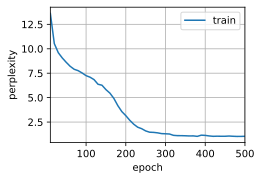

In [16]:
num_epochs, lr = 500, 1
train(net, train_iter, vocab, lr, num_epochs, try_gpu())

Finally, let us check the results of using the random sampling method.

perplexity 1.5, 91199.8 tokens/sec on cpu
time travellerit s against reason said filbywan a cube a anguste
travellerit s against reason said filbywan a cube a anguste


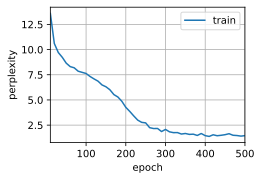

In [17]:
net = RNNModelScratch(len(vocab), num_hiddens, try_gpu(), get_params,
                      init_rnn_state, rnn)
train(net, train_iter, vocab, lr, num_epochs, try_gpu(),
          use_random_iter=True)

## Summary
* We can train an RNN-based character-level language model to generate text following the user-provided text prefix.
* A simple RNN language model consists of input encoding, RNN modeling, and output generation.
* RNN models need state initialization for training, though random sampling and sequential partitioning use different ways.
* When using sequential partitioning, we need to detach the gradient to reduce computational cost.
* A warm-up period allows a model to update itself (e.g., obtain a better hidden state than its initialized value) before making any prediction.
* Gradient clipping prevents gradient explosion, but it cannot fix vanishing gradients.

Here to answer question 1, I reduced the learning rate, increased the number of epochs and increased the number of hidden states. However, we see that that the perplexity does not fall much after 500 epochs.

perplexity 1.3, 20265.8 tokens/sec on cpu
time travellerit s against reason said filbywhat weashe sure we 
traveller after the pauserequired for the proper assimilati


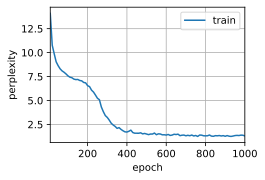

In [19]:
net = RNNModelScratch(len(vocab), 2 * num_hiddens, try_gpu(), get_params,
                      init_rnn_state, rnn)
train(net, train_iter, vocab, 0.75*lr, 2*num_epochs, try_gpu(),
          use_random_iter=True)
          

For this the learning rate is too hight for the model to successfully converge to a low perplexity compared to the previous instances.

perplexity 1.7, 19330.7 tokens/sec on cpu
time traveller held in his hand was a glitteringmetallic framewo
travelleryout the goume dimensions of spaceextran mativalf 


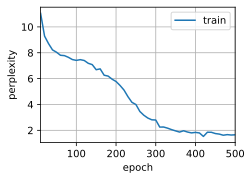

In [20]:
net = RNNModelScratch(len(vocab), 2 * num_hiddens, try_gpu(), get_params,
                      init_rnn_state, rnn)
train(net, train_iter, vocab, 1.5*lr, num_epochs, try_gpu(),
          use_random_iter=True)
          


## Exercises
1. Show that one-hot encoding is equivalent to picking a different embedding for each object.
   
   **A**: Embedding is a mapping of a discrete variable to a vector of contnuous numbers (https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526). If each object has a different embedding, then the number of unique values the vector can take equals the number of unique objects, which is basically one-hot encoding.

2. Adjust the hyperparameters (e.g., number of epochs, number of hidden units, number of time steps in a minibatch, and learning rate) to improve the perplexity.
   1. How low can you go?

      **A**: We want to increase the number of epochs and hidden units so that the model can fit better to the data. The number of time-steps in a minibatch should be an intermediate value and similarly with the learning rate.

      The minimum perplexity is 1, which was achieved by the sequential sampling procedure.

   2. Replace one-hot encoding with learnable embeddings. Does this lead to better performance?
   
      **A**: Learnable embeddings-- more on this in a future chapter. We see that one-hot encoding is generally pretty bad as the model cannot learn relationships between words. [To transform](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)

   3. How well will it work on other books by H. G. Wells, e.g., *The War of the Worlds*?

      **A**: There should not be a big difference on performance, unless the data it trains on is more comprehensive.
   
3. Modify the prediction function such as to use sampling rather than picking the most likely next character
   1. What happens?

         **A**: 

   2. Bias the model towards more likely outputs, e.g., by sampling from  for .

         **A**: 
   
4. Run the code in this section without clipping the gradient. What happens?

      **A**: Inability for convergence?

5. Change sequential partitioning so that it does not separate hidden states from the computational graph. Does the running time change? How about the perplexity?
6. Replace the activation function used in this section with ReLU and repeat the experiments in this section. Do we still need gradient clipping? Why?